In [22]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

output_directory = '/home/marco/DataspellProjects/thesis/output/pls/'

palette = sns.color_palette(["#2176AB", "#F97662", "#FFBF00", "#50C878", "#B284BE"])
sns.set(style="whitegrid", font_scale=1.5)
sns.set_palette(palette)

df = pd.read_excel('../../data/MTBLS92.xlsx', sheet_name='Data')
df= df[df['Class'].notna()]

#selecting only the columns with the metabolite names
df.describe()

,Idx,Class,Menopause,ER,Grade,Her2,N-stage,T-stage,M1,M2,...,M129,M130,M131,M132,M133,M134,M135,M136,M137,M138
count,253.000000,253.000000,253.000000,253.000000,243.000000,253.000000,253.000000,253.000000,253.000000,253.000000,...,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,127.000000,0.438735,1.415020,0.537549,2.304527,0.529644,0.616601,2.355731,0.811734,51.426928,...,8.293903,6.032206,4.325494,20.624024,9.620399,2.703553,12.011519,13.071375,14.561062,1.509961
std,73.179004,0.497216,0.493702,0.499576,0.580200,0.500110,0.666102,0.854457,0.176282,6.627746,...,4.575075,3.414120,5.999462,15.540656,7.167550,2.335686,7.745215,9.109715,13.637488,0.909001
min,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.466994,31.651906,...,1.466853,1.607654,0.611896,2.941342,1.263618,0.201810,2.044233,2.581575,1.440443,0.262536
25%,64.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.699523,47.912408,...,5.100323,4.065247,1.611820,10.241714,4.412546,1.302758,6.716963,7.051316,6.023649,0.899644
50%,127.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.794396,51.913497,...,7.424737,5.237880,2.653960,15.779160,7.876801,2.129753,10.146233,10.762540,10.561333,1.306207
75%,190.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.900307,55.599769,...,10.404067,6.828076,4.513811,26.048539,12.101917,3.243863,14.913364,15.428800,18.079229,1.898444
max,253.000000,1.000000,2.000000,1.000000,3.000000,1.000000,3.000000,5.000000,1.661150,67.652271,...,27.263676,24.431230,42.936089,112.969020,47.888619,19.737080,42.839125,61.256776,98.264030,6.686945


Performing PLSDA on the dataset using the roc_auc scoring metric and 10-fold cross validation.

In [23]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import numpy as np

df.fillna(method='ffill', inplace=True)

X = df.drop(columns=['Class', 'Idx']).iloc[:, 10:]
y = df['Class']


In [24]:
from sklearn.model_selection import StratifiedKFold

components = np.arange(1,20)
scores = []
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for i in components:
    kscores = []
    #10-fold cross validation
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pls = PLSRegression(n_components=i)
        pls.fit(X_train, y_train)
        y_pred = pls.predict(X_test)
        kscores.append(roc_auc_score(y_test, y_pred))
        
    scores.append(kscores)

#getting scores distribution for each number of components
scores = np.array(scores)
score_mean = np.mean(scores, axis=1)
score_std = np.std(scores, axis=1)
score_25 = np.quantile(scores, 0.25, axis=1)
score_75 = np.quantile(scores, 0.75, axis=1)


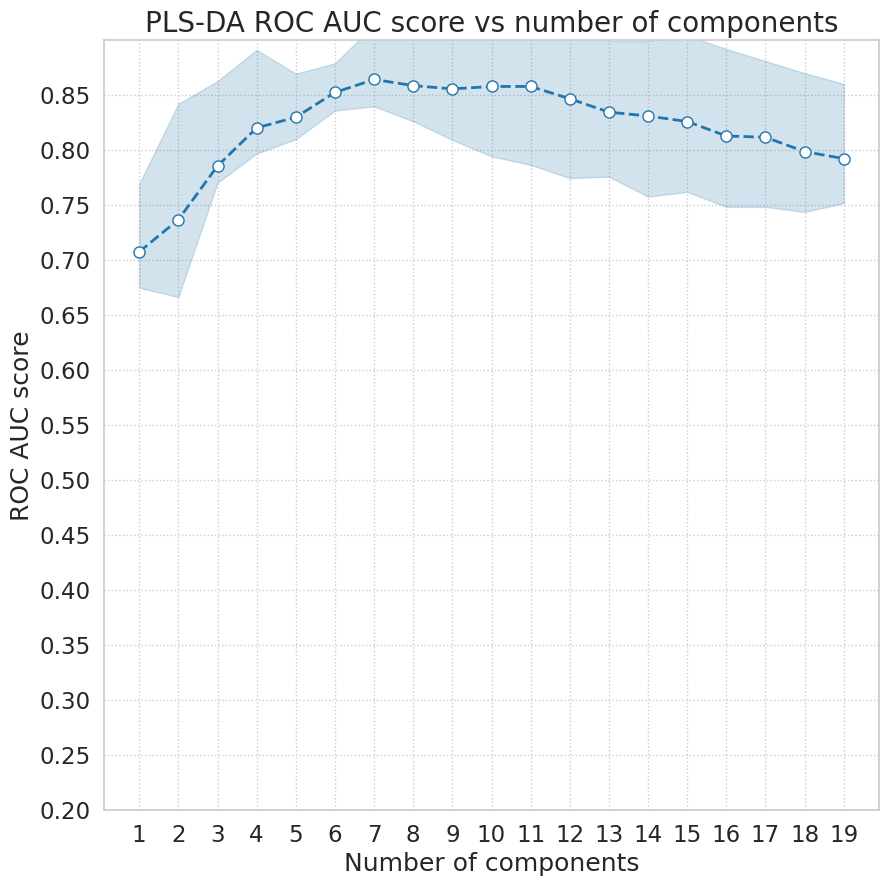

In [25]:
plt.figure(figsize=(10, 10))

# boxplot showing the distribution of the scores using line and markers
plt.plot(components, score_mean, color=palette[0], marker='o', markersize=8, linestyle='--', markeredgecolor=palette[0], markerfacecolor='white', linewidth=2)
plt.fill_between(components, score_25, score_75, color=palette[0], alpha=0.2)

# y axis limits
plt.ylim(0.2, 0.9)

# show plot grid
plt.xticks(components)
plt.yticks(np.arange(0.2, 0.9, 0.05))
plt.grid(True, linestyle=':', linewidth=1)
plt.xlabel('Number of components')
plt.ylabel('ROC AUC score')
plt.title('PLS-DA ROC AUC score vs number of components', fontsize=20)
plt.show()


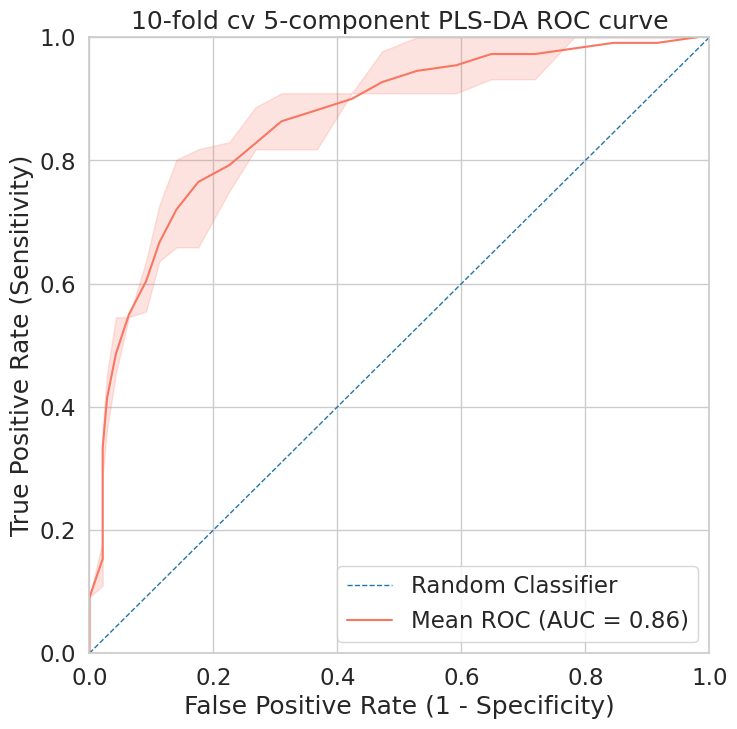

In [29]:
from sklearn.metrics import roc_curve, auc


roc_pls = PLSRegression(n_components=7)

roc_scores = dict()
roc_scores['fpr'] = []
roc_scores['tpr'] = []
roc_scores['roc_auc'] = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    roc_pls.fit(X_train, y_train)
    y_pred = roc_pls.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False)
    roc_scores['fpr'].append(fpr)
    roc_scores['tpr'].append(tpr)
    roc_scores['roc_auc'].append(auc(fpr, tpr))

plt.figure(figsize=(8, 8))
# plotting the random line
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', label='Random Classifier')

# Assicurati che tutte le liste di FPR e TPR abbiano la stessa lunghezza
max_length_fpr = min([len(lst) for lst in roc_scores['fpr']])
max_length_tpr = min([len(lst) for lst in roc_scores['tpr']])
roc_scores['fpr'] = [lst[:max_length_fpr] for lst in roc_scores['fpr']]
roc_scores['tpr'] = [lst[:max_length_tpr] for lst in roc_scores['tpr']]

# Calcola la media dei valori di FPR e TPR e l'AUC
mean_fpr = np.mean(roc_scores['fpr'], axis=0)
mean_tpr = np.mean(roc_scores['tpr'], axis=0)
mean_auc = np.mean(roc_scores['roc_auc'])

# Calcola 25 e 75 percentile
percentile_25_tpr = np.quantile(roc_scores['tpr'], 0.25, axis=0)
percentile_75_tpr = np.quantile(roc_scores['tpr'], 0.75, axis=0)

# Traccia la curva ROC media
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})')

# Traccia la regione di deviazione standard
plt.fill_between(mean_fpr, percentile_25_tpr, percentile_75_tpr, color=palette[1], alpha=0.2)

# Personalizza il grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('10-fold cv 5-component PLS-DA ROC curve')
plt.legend(loc='lower right')
plt.show()
